# Deep Generative Models for Genomics<a id='top'></a>
**Sections:**<br>
[0) Description](#0)<br>
[1) Importing Modules and Packages](#1)<br>
[2) Configuration](#2)<br>
[3) Utilities (utils)](#3)<br>
[4) DNA, RNA, Protein, or SNP Datasets (and other related functions)](#4)<br>
[5) Dataloader](#5)<br>
$\;\;$[&#x2092; Visualization of Real Data (batch-wise)](#51)<br>
[6) Networks](#6)<br>
$\;\;$[&#x2092; Multi-Layer Perceptron](#61)<br>
$\;\;$[&#x2092; ResNet 1D](#62)<br>
$\;\;$[&#x2092; ResNet 2D](#63)<br>
[7) Network (model) Instantiation and Optimizer setup](#7)<br>
$\;\;$[&#x2092; "torchviz"ualizing the (instantiated) Networks](#71)<br>
[8) Loading Pretrained Model (network checkpoints)](#8)<br>
[9) Model Training](#9)<br>
$\;\;$[&#x2092; Gradient Penalty Function (or some other helpful functions)](#91)<br>
$\;\;$[&#x2092; Training Loop (iteration)](#92)<br>
$\;\;$[&#x2092; Training Curves and Stats](#93)<br>
[10) Evaluation and Visualisation (generated sequences)](#10)<br>
[11) TO-DO List to Extend the Model](#11)<br>

In [0]:
colab = True
# In case in Colab activate this cell by passing the corect path to the images
if colab==True: 
    from google.colab import drive
    drive.mount('/content/drive')
    imgs_dir = 'drive/My Drive/AIGenomics101/'
else:
    imgs_dir = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Description<a id='0'></a>
[back to top](#top)<br>

#### Paper:  Generating and designing DNA with deep generative models ([link](https://arxiv.org/abs/1712.06148))
##### Abstract
We propose generative neural network methods to generate DNA sequences and tune them to have desired properties. We present three approaches: creating synthetic DNA sequences using a generative adversarial network; a DNA-based variant of the activation maximization ("deep dream") design method; and a joint procedure which combines these two approaches together. We show that these tools capture important structures of the data and, when applied to designing probes for protein binding microarrays, allow us to generate new sequences whose properties are estimated to be superior to those found in the training data. We believe that these results open the door for applying deep generative models to advance genomics research.

## Importing Modules and Packages<a id='1'></a>
[back to top](#top)<br>

In [0]:
!pip install logomaker
!pip install torchviz

In [0]:
import os
from os import path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import socket
import datetime
import random
import re
import requests
import gzip
import logomaker # https://github.com/jbkinney/logomaker/tree/master/logomaker/tutorials
import easydict
from pytz import timezone

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

## Configuration<a id='2'></a>
[back to top](#top)<br>

In [0]:
tz = timezone('US/Eastern')  # To monitor training time (showing start & end points of a fixed timezone when the code runs on a remote server)

#checkpoint = "/mnt/wd_4tb/shared_disk_wd4tb/ahmad/Generating-and-designing-DNA/scripts/log/gan_test/2020.02.10-23h52m43s_kepler/checkpoints/checkpoint_1000"
checkpoint = None

args = easydict.EasyDict({
        "generic": True,             # Generate generic data on the fly (ignores data_loc and data_start args)
        "pseudo_data": "pattern2",    # If 'generic=True', how to simulate sequence of nucllitides ('random', 'pattern1' or 'pattern2')
        "motif": True,                # If 'generic=True', if we want to have a motif also occuring in the simulated sequence
        "motif_match": "GTATT[AC]A",  # If 'motif=True', what would be the motif pattern accurning in each nth position (motif_nth_position) of a simulated sequence
        "motif_nth_position": 10,     # If 'motif=True', motif pattern tend to occur in each nth position (motif_nth_position) of a simulated sequence
        "motif_max": 2,               # If 'motif=True', maximum number of motifs in a simulated sequence
        "data_loc": "dataset/",       # Data location (create if it does not exist)
        "dataset_name": "chr1.fa.gz", # Name of the dataset in 'data_loc' to be loaded and trained/evaluated on
        "data_start": 0,              # Line number to start when parsing data (useful for ignoring header)
        "log_dir": "log/",            # Base log folder (create if it does not exist)
        "log_name": "gan_test",       # Name to use when logging this model
        "checkpoint": checkpoint,     # Foldername of checkpoint to load (full directory)
        "model_type": "mlp",          # Which type of model architecture to use ('mlp', 'resnet1d', 'resnet2d', etc)
        "train_iters": 1000,          # Number of iterations to train GAN for
        "disc_iters": 1,              # Number of iterations to train discriminator for at each training step
        "checkpoint_iters": 250,      # Number of iterations before saving checkpoint
        "latent_dim": 32,             # Size of latent space
        "gen_dim": 64,                # Size of each hidden layer in Generator
        "disc_dim": 64,               # Size of each hidden layer in Discriminator
        "gen_layers": 2,              # How many (middle or hidden) layers in Generator (ie. 'mlp': w/o 1st & last; 'resnet's: num. resudual blocks)
        "disc_layers": 2,             # How many (middle or hidden) layers in Discriminator (ie. 'mlp':  w/o 1st & last; 'resnet's: num. resudual blocks)
        "batch_size": 64,             # Batch size
        "max_seq_len": 36,            # Maximum sequence length of data
        "vocab": "dna",               # Which vocabulary to use. Options are 'dna', 'rna', 'dna_nt_only', and 'rna_nt_only'.
        "vocab_order": None,          # Specific order for the one-hot encodings of vocab characters
        "annotate": False,            # Include annotation as part of training/generation process?
        "validate": True,             # Whether to use validation set
        "learning_rate": 0.004,       # Learning rate for the optimizer
        "beta1": 0.5,                 # 'beta1' for the optimizer
        "lmbda": 10,                  # 'lmbda' for Lipschitz gradient penalty hyperparameter
        "reproducible": True,         # Do we want to have a reproducible result?
        "seed": 1234,                 # Seed used for Random Number Generation if 'reproducible=True'
})

# sets device for model and PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

# set RNG
if args.reproducible:
    seed = args.seed
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type=='cuda': torch.cuda.manual_seed_all(seed)

## Utilities (utils)<a id='3'></a>
[back to top](#top)<br>

In [0]:
"""extra utility functions"""
    
def log(args, samples_dir=False):
    """Create logging directory structure according to args."""
    if hasattr(args, "checkpoint") and args.checkpoint:
        return _log_from_checkpoint(args)
    else:
        stamp = datetime.date.strftime(datetime.datetime.now(), "%Y.%m.%d-%Hh%Mm%Ss") + "_{}".format(socket.gethostname())
        full_logdir = os.path.join(args.log_dir, args.log_name, stamp)
        os.makedirs(full_logdir, exist_ok=True)
        if samples_dir: os.makedirs(os.path.join(full_logdir, "samples"), exist_ok=True)
        args.log_dir = "{}:{}".format(socket.gethostname(), full_logdir)
        _log_args(full_logdir, args)
    return full_logdir, 0

def _log_from_checkpoint(args):
    """Infer logging directory from checkpoint file."""
    int_dir, checkpoint_name = os.path.split(args.checkpoint)
    logdir = os.path.dirname(int_dir)
    checkpoint_num = int(checkpoint_name.split('_')[1])
    _log_args(logdir, args, modified_iter=checkpoint_num)
    return logdir, checkpoint_num

def _log_args(logdir, args, modified_iter=0):
    """Write log of current arguments to text."""
    keys = sorted(arg for arg in dir(args) if not arg.startswith("_"))
    args_dict = {key: getattr(args, key) for key in keys}
    with open(os.path.join(logdir, "config.txt"), "a") as f:
        f.write("Values at iteration {}\n".format(modified_iter))
        for k in keys:
            s = ": ".join([k,str(args_dict[k])]) + "\n"
            f.write(s)
        vocab_order = args.vocab_order if hasattr(args, "vocab_order") else None
        charmap, _ = get_vocab(args.vocab, vocab_order)
        charmap_strs = []
        for k,v in charmap.items():
            charmap_strs.append("'{}':{}".format(k,v))
        f.write("charmap: " + ", ".join(charmap_strs))
        f.write("\n")

def save_samples(logdir, samples, iteration, rev_charmap, annotated=False):
    """Convert samples to strings and save to log directory."""
    if annotated:
        char_probs = samples[:,:-1,:]
        ann = samples[:,-1,:]
    else:
        char_probs = samples
    argmax = np.argmax(char_probs, 1)
    with open(os.path.join(logdir, "samples", "samples_{}".format(iteration)), "w") as f:
        for line in argmax:
            s = "".join(rev_charmap[d] for d in line) + "\n"
            f.write(s)
    if annotated:
        np.savetxt(os.path.join(logdir, "samples", "samples_ann_{}".format(iteration)), ann)

def plot(y, x, logdir, name, xlabel=None, ylabel=None, title=None, save=True):
    """Make plot of training curves"""
    plt.close()
    plt.plot(y,x)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title = title
    if save:
        plt.savefig(os.path.join(logdir, "{}".format(name) + ".png"))
        plt.close()

def feed(data, batch_size, reuse=True):
    """Feed data in batches"""
    if type(data)==list or type(data)==tuple and len(data)==2:
        data_seqs, data_vals = data
        yield_vals = True
    else:
        data_seqs = data
        yield_vals = False
    num_batches = len(data_seqs) // batch_size
    if num_batches == 0:
        raise Exception("Dataset not large enough to accomodate batch size")
    while True:
        for ctr in range(num_batches):
            out = data_seqs[ctr * batch_size : (ctr + 1) * batch_size]
            if yield_vals:
                out = (out, data_vals[ctr * batch_size : (ctr + 1) * batch_size])
            yield out
        if not reuse and ctr == num_batches - 1:
            yield None

def onehots_to_charmap(onehots, rev_charmap, model_type="resnet2d", generic=True):
    """Function to transfer a onehoted sequence to its equivalent charmaps"""
    st = ""
    if model_type == "mlp":
        length = len(rev_charmap)
        onehots = np.reshape(onehots, [-1 , length])
        for _ in onehots:
            st = st+rev_charmap.get(np.argmax(_), "-") 
        return st
    if model_type == "resnet1d" or model_type == "resnet2d":
        onehots_transposed = zip(*onehots)
        for _ in onehots_transposed:
            st = st+rev_charmap.get(np.argmax(_), "-") 
        return st

def charmap_to_onehots(chars, charmap, model_type="resnet2d"):
    """Function to transfer a charmaps to its equivalent onehoted sequence"""
    onehots = np.int_(np.zeros([len(chars), vocab_size]))
    for i, char in enumerate(chars):
        onehots[i] = I[charmap[char]]
        
    if model_type == "mlp":
        onehots = np.reshape(onehots, [-1])
    if model_type == "resnet1d" or model_type == "resnet2d":
        onehots = onehots.T
    return onehots

def motif_matches(data):
    """Function to return a list of 'motif matches' when [] is used in 'motif_matche'"""
    list_mtfs = []
    list_temp = []
    if "[" in data:
        list_temp.append(data)
    else:
        list_mtfs.append(data)
    while 0<len(list_temp): # while list_temp has elements in which '[]' exist unwrap them
        st = list_temp[0]
        ntss = re.findall("\[(.*?)\]", st) # find elements in []
        for nts in ntss:
            for nt in nts:
                ss = st.replace("["+nts+"]", nt)  # replace '[xyz]' with 'x', 'y', or, 'z' 
                if "[" in ss and ss not in list_temp:  # not completely done done 
                    list_temp.append(ss)
                else:        # completely done done 
                    if ss not in list_mtfs: list_mtfs.append(ss)
        list_temp.remove(st)
    return list_mtfs

def logo_draw(matrix, title="", xlabel="", ylabel="", figsize=(9,2.5), dpi=80, center_values=False, 
              motif_nth_position=None, motif_match_len=None, save=True, logdir=None):
    """
    A wrapper for logomaker: 
    https://github.com/jbkinney/logomaker/tree/master/logomaker/tutorials
    """
    # some initial representation settings
    color_scheme = {'A': 'blue',
                    'C': 'orange',
                    'G': 'green',
                    'T': 'red',
                    'U': 'red',
                    '*': 'black',
                    '-': 'yellow'} # to get all 'color_scheme' logomaker.list_color_schemes()
    font_name = 'FreeSans' # to get all 'font_name' logomaker.list_font_names()
    
    # matplotlib Axes object
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.axes()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # making a logo
    logo = logomaker.Logo(matrix, color_scheme=color_scheme, font_name=font_name, ax=ax, center_values=center_values)
    # style logo spines
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left','bottom'], visible=True, linewidth=1)
    
    if motif_nth_position:
        assert motif_match_len is not None, "You need to define the length of the motif"
        logo.highlight_position_range(args.motif_nth_position*1,args.motif_nth_position*1+motif_match_len-1,
                                      alpha=0.5,color='lightgray')
        logo.highlight_position_range(args.motif_nth_position*2,args.motif_nth_position*2+motif_match_len-1,
                                      alpha=0.3,color='lightblue',edgecolor='black')
    # style and save figure
    #fig.tight_layout()
    if save:
        assert logdir!=None, "Pass the 'logdir' to determine where to save the figures of the sequence logos"
        logo_dir = os.path.join(logdir, "logos")
        os.makedirs(logo_dir, exist_ok=True)
        plt.savefig(os.path.join(logo_dir, "{}".format(title) + ".png"))
        
def z_sampler(batch_size, latent_dim):
    """Function to provide noise that will be fed to the generator"""
    return Variable(torch.randn(batch_size, latent_dim)).to(device)

def save_models(logdir, generator, discriminator, true_count):
    """Function to save Denerator and Discriminator models (checkpointing)"""
    ckpt_dir = os.path.join(logdir, "checkpoints", "checkpoint_{}".format(true_count))
    os.makedirs(ckpt_dir, exist_ok=True)
    torch.save(generator.state_dict(), '{}/netG'.format(ckpt_dir))
    torch.save(discriminator.state_dict(), '{}/netD'.format(ckpt_dir))

## DNA, RNA, Protein, or SNP Datasets (and other related functions)<a id='4'></a>
[back to top](#top)<br>

In [0]:
"""Helpers for working with DNA/RNA data"""

# fix vocabulary
dna_vocab = {"A":0,
             "C":1,
             "G":2,
             "T":3,
             "*":4} # catch-all auxiliary token
rna_vocab = {"A":0,
             "C":1,
             "G":2,
             "U":3,
             "*":4}

dna_nt_only_vocab = {k:v for k,v in dna_vocab.items() if k in "ACGT"} # dna nucleotides only
rna_nt_only_vocab = {k:v for k,v in rna_vocab.items() if k in "ACGU"} # rna nucleotides only

rev_dna_vocab = {v:k for k,v in dna_vocab.items()}
rev_rna_vocab = {v:k for k,v in rna_vocab.items()}
rev_dna_nt_only_vocab = {v:k for k,v in dna_nt_only_vocab.items()}
rev_rna_nt_only_vocab = {v:k for k,v in rna_nt_only_vocab.items()}

def get_vocab(vocab_name, vocab_order=None):
    if vocab_name=="dna":
        charmap = dna_vocab
    elif vocab_name=="rna":
        charmap = rna_vocab
    elif vocab_name=="dna_nt_only":
        charmap = dna_nt_only_vocab
    elif vocab_name=="rna_nt_only":
        charmap = rna_nt_only_vocab
    else:
        raise Exception("Unknown vocabulary name.")

    if vocab_order:
        if set(vocab_order) != set(charmap):
            raise ValueError("Provided `vocab` and `vocab_order` arguments are not compatible")
        else:
            charmap = {c: idx for idx, c in enumerate(vocab_order)}

    rev_charmap = {v: k for k, v in charmap.items()}
    return charmap, rev_charmap

def _process_line(line, max_len, charmap):
    chars = line
    I = np.eye(len(charmap))
    try:
        base = [I[charmap[c]] for c in chars]
        if len(chars) < max_len:
            extra = []
            if "*" in charmap:
                extra = [I[charmap["*"]]] * (max_len - len(chars))
        else:
            extra = []
        arr = np.array(base + extra)
    except:
        raise Exception("Unable to process line: {}".format(chars))
    return np.expand_dims(arr, 0)

def load(data_loc, vocab, max_seq_len=None, vocab_order=None, data_start_line=0, 
         scores=False, valid=False, test=False, filenames=None, annotate=False, file_format=None, model_type="resnet2d"):
    charmap, _ = get_vocab(vocab, vocab_order)
    
    if filenames=="chr1.fa.gz":
        # Download fasta data of Chromosome 1 into dataset folder (if it does not exist already)
        if not path.exists('{}/chr1.fa.gz'.format(data_loc)):
            os.makedirs(data_loc, exist_ok=True)  # create 'data_loc' folder (if it does not exist already)
            print("Downloading 'chr1.fa.gz' dataset (human chromosome 1 sequence) to the directory '{}' ....".format(args.data_loc))
            url = 'http://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr1.fa.gz'  # (UCSC Genome Browser) http://hgdownload.soe.ucsc.edu/downloads.html >> human >> Sequence data by chromosome
            r = requests.get(url, allow_redirects=True)
            open('{}/chr1.fa.gz'.format(data_loc), 'wb').write(r.content)
        seq_filenames = ["chr1.fa.gz"]
    elif filenames!="chr1.fa.gz":   # or other conditions can be added later
        for filename in filenames:
            assert path.exists('{}/{}'.format(data_loc, filename)), "The dataset of interest is not found in the dataset drirectory!"
        if type(filenames)==list:
            seq_filenames = filenames
        else:
            seq_filenames = [filenames]
    else:
        seq_filenames = ["train_data.txt"]
        if valid:
            seq_filenames.append("valid_data.txt")
        if test:
            seq_filenames.append("test_data.txt")

    data = []
    for name in seq_filenames:
        
        if file_format=='gz':
            with gzip.open(os.path.join(data_loc, name), 'rt') as f:
                lines = f.readlines()
        else:
            with open(os.path.join(data_loc, name)) as f:
                lines = f.readlines()
        lines = lines[data_start_line:100000]
        if not max_seq_len:
            max_seq_len = len(max(lines, key=len)) - 1
            print("Warning: 'max_seq_len' not provided. Inferring size from data... '(args.)max_seq_len' is set to {}.\n".format(max_seq_len))
            args.max_seq_len = max_seq_len
        lines_processed = []
        for line in lines:
            line = line.strip().upper()
            if set(line)<=set(charmap):
                lines_processed.append(_process_line(line, max_seq_len, charmap))
        data.append(np.vstack(lines_processed))

        if scores:
            score_filename = name.split("_")[0] + "_vals.txt"
            scores_array = np.loadtxt(os.path.join(data_loc, score_filename), skiprows=data_start_line)
            data.append(scores_array)

        if annotate:
            ann_filename = name.split("_")[0] + "_ann.txt"
            ann_array = np.loadtxt(os.path.join(data_loc, ann_filename), skiprows=data_start_line)
            ann_array = np.expand_dims(ann_array, 2)
            data.append(ann_array)
    if type(data) == list and len(data) == 1:
        data = data[0]
    if model_type=="mlp":
        return np.reshape(data, [data.shape[0], -1])
    elif model_type=="resnet1d" or model_type=="resnet2d":
        return np.transpose(data, (0, 2, 1))

## Dataloader<a id='5'></a>
[back to top](#top)<br>

In [0]:
# load dataset

# fix vocabulary of model
charmap, rev_charmap = get_vocab(args.vocab, args.vocab_order)
vocab_size = len(charmap)
print("charmap:", charmap)
print("rev_charmap:", rev_charmap)
print("vocab_size:", vocab_size)

I = np.eye(vocab_size)

    
if args.generic:
    if args.annotate: raise Exception("args `annotate` and `generic` are incompatible.")

    def pseudo_sequence(batch_size, seq_len, vocab_size, pseudo_data="random", model_type="resnet2d", data_len=None):
        """Genertor to generating random sequences for toy test of gnerative model"""
        if data_len:
            assert batch_size <= data_len, "Make sure 'data_len' (num of samples) is not smaller than 'batch_size'"
            feed_ctr = 0
        I = np.eye(vocab_size)
        while True:
            samples = np.random.choice(vocab_size, [batch_size, seq_len])
            if pseudo_data=="pattern1" or pseudo_data=="pattern2":
                temp = np.random.choice(vocab_size, batch_size)+1
                for i, j in enumerate(temp):
                    for j in range(seq_len):
                        samples[i, j]= temp[i]
                        if pseudo_data=="pattern1":
                            temp[i] = temp[i]%vocab_size+1
                        elif pseudo_data=="pattern2":
                            if np.random.uniform()<temp[i]/vocab_size:
                                temp[i] = temp[i]%vocab_size+1
                    samples[i] = samples[i]-1
            
            
            if args.motif:
                # First, unwrapping possible motifs
                assert set(args.motif_match)-set(["[","]"]) <= set(charmap), "Make sure all the characters of 'motif_match' is allowed in 'vocab'"                   
                list_mtfs = []
                list_temp = []
                if "[" in args.motif_match:
                    list_temp.append(args.motif_match)
                else:
                    list_mtfs.append(args.motif_match)
                while 0<len(list_temp): # while list_temp has elements in which '[]' exist unwrap them
                    st = list_temp[0]
                    ntss = re.findall("\[(.*?)\]", st) # find elements in []
                    for nts in ntss:
                        for nt in nts:
                            ss = st.replace("["+nts+"]", nt)   # replace '[xyz]' with 'x', 'y', or, 'z' 
                            if "[" in ss and ss not in list_temp:  # not completely done done 
                                list_temp.append(ss)
                            else:        # completely done done 
                                if ss not in list_mtfs: list_mtfs.append(ss)
                    list_temp.remove(st)
                motifs = list_mtfs # list of possible motifs
                
                # Now, inserting motifs (randomly) in the sequence at 'motif_nth_position'
                for _ in range(args.motif_max):
                    motifchar = np.random.choice(motifs) # randomly chosing a possible motif
                    motif = [charmap[char] for char in motifchar]
                    for i in range(len(samples)):
                        rand = (np.random.choice(args.max_seq_len)//args.motif_nth_position)*args.motif_nth_position
                        if args.max_seq_len<rand+len(motif):
                            indx = rand+len(motif)-args.max_seq_len
                            samples[i][rand:rand+len(motif)-indx] = motif[0:len(motif)-indx]
                        else:
                            samples[i][rand:rand+len(motif)] = motif
                            
            data = np.vstack([np.expand_dims(I[vec],0) for vec in samples])
            
            if model_type=="mlp":
                reshaped_data = np.reshape(data, [batch_size, -1])
            elif model_type=="resnet1d" or model_type=="resnet2d":
                reshaped_data = np.transpose(data, (0, 2, 1))#np.reshape(data, [batch_size, vocab_size, args.max_seq_len])
            if data_len:
                feed_ctr += batch_size
                if feed_ctr > data_len:
                    feed_ctr = 0
                    yield None
                else:
                    yield reshaped_data
            else:
                yield reshaped_data

    train_seqs = pseudo_sequence(batch_size=args.batch_size, seq_len=args.max_seq_len, vocab_size=vocab_size, 
                                 pseudo_data=args.pseudo_data, model_type=args.model_type, data_len=None)
    
    if args.validate: 
        valid_seqs = pseudo_sequence(batch_size=args.batch_size, seq_len=args.max_seq_len, vocab_size=vocab_size, 
                                     pseudo_data=args.pseudo_data, model_type=args.model_type, data_len=10000)

else:
    data = load(args.data_loc, args.vocab, data_start_line=1, filenames=args.dataset_name, file_format='gz',
                valid=args.validate, annotate=args.annotate, model_type=args.model_type) # if nothing goes wrong (4609492, 50, 5)
    np.random.shuffle(data)
    if args.validate:
        split = len(data) // 2
        train_data = data[:split]
        valid_data = data[split:]
        if len(train_data) == 1: train_data = train_data[0]
        if len(valid_data) == 1: valid_data = valid_data[0]
    else:
        train_data = data
    if args.annotate:
        if args.validate: valid_data = np.concatenate(valid_data, 2)
        train_data = np.concatenate(train_data, 2)

    def feed(data, model_type, batch_size=args.batch_size, reuse=True):
        num_batches = len(data) // batch_size
        if model_type=="mlp":
            reshaped_data = np.reshape(data, [data.shape[0], -1])
        elif model_type=="resnet1d" or model_type=="resnet2d":
            reshaped_data = data
        while True:
            for ctr in range(num_batches):
                yield reshaped_data[ctr * batch_size : (ctr + 1) * batch_size]
            if not reuse and ctr == num_batches - 1:
                yield None
    train_seqs = feed(train_data, args.model_type)
    valid_seqs = feed(valid_data, args.model_type, reuse=False)

charmap: {'A': 0, 'C': 1, 'G': 2, 'T': 3, '*': 4}
rev_charmap: {0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: '*'}
vocab_size: 5


In [0]:
# organize model logs/checkpoints
logdir, checkpoint_baseline = log(args, samples_dir=True)
    
if args.annotate:
    data_enc_dim = vocab_size + 1
else:
    data_enc_dim = vocab_size
data_size = args.max_seq_len * data_enc_dim

In [0]:
# Defining the length of a motif match (whether w or w/o '[]')
motif_match_len = len(motif_matches(args.motif_match)[0])
motif_match_len

7

#### Visualization of Real Data (batch-wise)<a id='51'></a>
[back to top](#top)<br>

In [0]:
#################################################
### generating some 'pseudo sequence' samples ###
#################################################

seqs = next(train_seqs)
print("Shape of this batch is {} for the model type '{}'.\n".format(seqs.shape, args.model_type))

nt_seqs = []
for b in range(10): # collect information of 10 batches in 'nt_seqs'
    for i in range(len(seqs)):
        nt_seq = onehots_to_charmap(seqs[i], rev_charmap, args.model_type, args.generic)
        if b==0: print(i, " ", nt_seq) # show the first batch sequences
        nt_seqs.append(nt_seq)
    seqs = next(train_seqs)

Shape of this batch is (64, 180) for the model type 'mlp'.

0   GTATTCACCCGTATTCAAAAAAAAAAAAAAAAAAAA
1   GTATTCACCCGGGGGT*AACCCCGGT*AAAAACGGG
2   ACGGGGGTTTGTATTCACCCGTATTCACGT*AACCC
3   CGT*AACCGGGTATTCAAAAGTATTCACGGGT*AAA
4   GTATTCAAAAAAAACGGT*AAAAAAAAAAAGTATTC
5   TT*AAAAAAAGTATTCAAAAGTATTCAGT*AAAAAC
6   GTATTCACGTT*AAAACGGT*AAAAAAAAAGTATTC
7   ACGT*ACCCCCCGT*AACGGGTATTCAAAAGTATTC
8   T*AAACCGGGGTATTCAAAAAAAAACGT*AGTATTC
9   *AAAAAAAAAGTATTCAGT*AAAAAACGT*ACCGT*
10   TT*AACCCGGGGGGGT*AAAGTATTCAAAAGTATTC
11   *AAAAACCCCGTATTCAAAAGTATTCAAACCGT*AA
12   GTATTCAAAACCGTT*AAAAGTATTCAAACCGT*AA
13   GTTT*ACGT*ACCGGGGT*AGTATTCA*AAAAAAAA
14   *AAAAACGT*GTATTCAGT*AAACGGGT*AAAAAAA
15   T*AAACCCCCGTATTCAAAAGTATTCA*ACGGGGTT
16   GTATTCA*AACGT*AAAACCGTATTCAGT*AACGGT
17   GT*ACCGTTT*AAACCGT*ACCCCGGT*AAGTATTC
18   GTATTCAAAAGTATTCACGGT*AAAACCCCCGGGGG
19   GT*AAACGGGGTATTCACGTGTATTCACGGGT*AAA
20   CCGGT*AAAAAACCCCCGTTGTATTCAACCGTATTC
21   AAACGT*AACCGT*ACCGTTGTATTCAGT*AAAACC
22   GTATTCAAAAGTATTCAAAAA

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


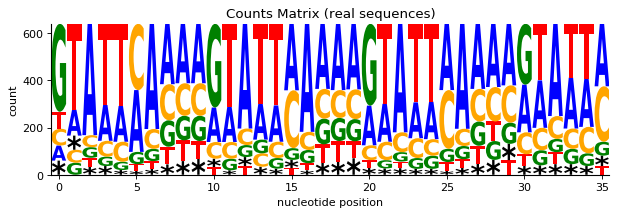

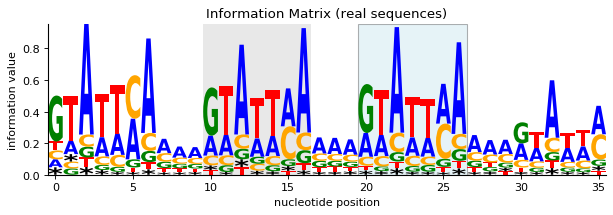

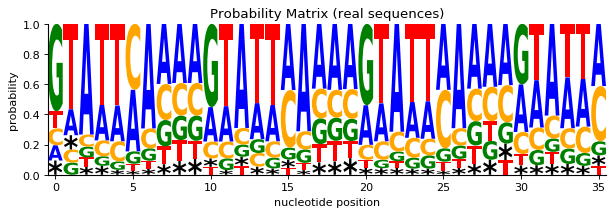

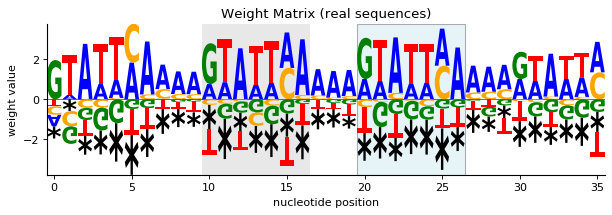

In [0]:
############################
### Sequence logo design ###
############################

"""Counts matrix"""
counts_mat = logomaker.alignment_to_matrix(nt_seqs)
logo_draw(counts_mat, title="Counts Matrix (real sequences)", xlabel="nucleotide position", ylabel="count", logdir=logdir)

"""Counts matrix -> Information matrix"""
info_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='information')
logo_draw(info_mat, title="Information Matrix (real sequences)", xlabel="nucleotide position", ylabel="information value", 
                                      motif_nth_position=args.motif_nth_position, motif_match_len=motif_match_len, logdir=logdir)

"""Information matrix -> Probability matrix"""
prob_mat = logomaker.transform_matrix(info_mat, from_type='information', to_type='probability')
logo_draw(prob_mat, title="Probability Matrix (real sequences)", xlabel="nucleotide position", ylabel="probability", logdir=logdir)

"""Counts matrix -> weight matrix"""
# create a user specified background
gc = .51
if counts_mat.shape[1]==5:
    background = [(1-gc)/2, gc/2, gc/2, gc/2, (1-gc)/2]
elif counts_mat.shape[1]==4:
    background = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
weight_mat = logomaker.transform_matrix(counts_mat, background=background, from_type='counts', to_type='weight')
logo_draw(weight_mat, title="Weight Matrix (real sequences)", xlabel="nucleotide position", ylabel="weight value",
          motif_nth_position=args.motif_nth_position, motif_match_len=motif_match_len, center_values=True, logdir=logdir)

## Networks<a id='6'></a>

#### Multi-Layer Perceptron<a id='61'></a>
[back to top](#top)<br>

In [0]:
Image(imgs_dir+'imgs/MLP/MLP_for_DNA_Nucleotides.png', width="1400")

In [0]:

class mlp_generator(nn.Module):
    """ Multi-Layer Perceptron for generating sequences."""
    # TO-DO
    # Linear->ReLU
    # For last layer try different activation function


class mlp_discriminator(nn.Module):
    """ Multi-Layer Perceptron for discriminating real vs generated sequences."""
    # TO-DO
    # Linear->LeakyReLU
    # For last layer do we need any activation function? (have a look at 'criterion' defined)


#### Convolutional 1D (ResNet-based)<a id='62'></a>
[back to top](#top)<br>

In [0]:
Image(imgs_dir+'imgs/1D_Conv/1D_Conv_for_DNA_Nucleotides.png', width="1400")

"""Example to show the number of parameters in an 'nn.Conv1d' layer"""
#inpute = torch.randn(1, 5, 10) # 5 shannels of row vectors with the size 10 (1 can be seen ast the batch size)
layer = nn.Conv1d(in_channels=3, out_channels=5, kernel_size=(2,), padding=2//2, bias=True)
weight = {0:"conv1d kernels", 1: "conv1d biases"}

for i, parameter in enumerate(layer.parameters()):
    print("Parameter shape ({}):".format(weight[i]), parameter.shape)
    if "kernel" in weight[i]:
        print ("i.e.: [num_superkernels(out_channels)={}, num_subkernels_in_a_superkernel(in_channels)={}, subkernel_length={}]\n"
               .format(parameter.shape[0], parameter.shape[1], parameter.shape[2]))
    elif "bias" in weight[i]:
        print ("i.e.: [num_superkernels(out_channels)={}]\n".format(parameter.shape[0]))

In [0]:
   
class resblock_1d(nn.Module):
    """Class to return a block of 1D Resudual Networks"""
    # TO-DO
    # generator: conv1d->BatchNorm->ReLU
    # discriminator: conv1d->BatchNorm->LeakyReLU
    # Explore different kernel sizes: 3, 5, 7, 11, 13, ..., 19, 21


class resnet_generator_1d(nn.Module):
    """ Resudual Network with 1D convolutions for generating sequences."""
    # TO-DO
    # will use 'resblock_1d' module inside


class resnet_discriminator_1d(nn.Module):
    """ Resudual Network with 1D convolutions for discriminating real vs generated sequences."""
    # TO-DO
    # will use 'resblock_1d' module inside


#### Convolutional 2D (ResNet-based)<a id='63'></a>
[back to top](#top)<br>

In [0]:
Image(imgs_dir+'imgs/2D_Conv/2D_Conv_for_DNA_Nucleotides.png', width="1400")

In [0]:
   
class resblock_2d(nn.Module):
    """Class to return a block of 2D Resudual Networks"""
    # TO-DO
    # generator: conv2d->BatchNorm->ReLU
    # discriminator: conv2d->BatchNorm->LeakyReLU
    # # Explore different kernel sizes: (3, 1), (3, 3), (3, 5), (7, 1), (7, 3), (7, 5), (11, 1), 13, ..., (19, 1), (19, 3), (19, 5), (21, 1), (21, 3), (21, 5)


class resnet_generator_2d(nn.Module):
    """ Resudual Network with 2D convolutions for generating sequences."""
    # TO-DO
    # will use 'resblock_2d' module inside

    
class resnet_discriminator_2d(nn.Module):
    """ Resudual Network with 2D convolutions for discriminating real vs generated sequences.""""
    # TO-DO
    # will use 'resblock_2d' module inside


SyntaxError: ignored

## Network (model) Instantiation and Optimizer setup<a id='7'></a>
[back to top](#top)<br>

In [0]:
# instantiate models
if args.model_type=="mlp":
    netG = mlp_generator(args.gen_dim, args.latent_dim, args.max_seq_len*vocab_size, args.gen_layers).to(device)
    netD = mlp_discriminator(args.disc_dim, args.max_seq_len*vocab_size, args.disc_layers).to(device)
elif args.model_type=="resnet1d":
    netG = resnet_generator_1d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_1d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)
elif args.model_type=="resnet2d":
    netG = resnet_generator_2d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_2d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)

print("{}\nGenerator Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, netG))
print("{}\nDiscriminator Network Architecture:\n{}\n{}\n".format("="*35, "~"*35, netD))

# cost function (for discriminator prediction)
criterion = nn.BCEWithLogitsLoss()

# setup optimizer
optimizerG = optim.Adam(list(netG.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))
optimizerD = optim.Adam(list(netD.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))

# use an exponentially decaying learning rate
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)
schedulerD= optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)

TypeError: ignored

#### "torchviz"ualizing the (instantiated) Networks<a id='71'></a>
[back to top](#top)<br>

In [0]:
from torchviz import make_dot, make_dot_from_trace

In [0]:
x = z_sampler(args.batch_size,args.latent_dim)
make_dot(netG(x), params=dict(list(netG.named_parameters())))

NameError: ignored

In [0]:
real_seqs = next(train_seqs)
real_seqs = Variable(torch.tensor(real_seqs).float().to(device))
print(real_seqs.shape)
make_dot(netD(real_seqs), params=dict(list(netD.named_parameters())))

torch.Size([64, 180])


NameError: ignored

## Loading Pretrained Model (network checkpoints)<a id='8'></a>
[back to top](#top)<br>

In [0]:
if args.checkpoint:
    ckpt_dir = os.path.join(logdir, "checkpoints", "checkpoint_{}".format(checkpoint_baseline))
    netG.load_state_dict(torch.load('{}/netG'.format(ckpt_dir)))
    netD.load_state_dict(torch.load('{}/netD'.format(ckpt_dir)))
    
    for param in netG.parameters():
        param.requires_grad = True
                                      
    for i in range(checkpoint_baseline):
        schedulerG.step()
        schedulerD.step()
    print(schedulerG.get_lr())

## Model Training<a id='9'></a>
[back to top](#top)<br>

Compact loss function for GAN for both $G$ and $D$:<br>$$
\min _{G} \max _{D} V(D, G) = \min _{\theta_{g}} \max _{\theta_{d}}\left[\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data}}(\boldsymbol{x})} \log D_{\theta_{d}}(x)+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{x}}(\boldsymbol{z})} \log \left(1-D_{\theta_{d}}\left(G_{\theta_{g}}(z)\right)\right)\right]
$$

For $D$ (Discriminator) training:<br>
$$\max _{D} V(D)=\max _{\theta_{d}} \left[\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{x}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]\right]$$<br><br>

Drived from Loss function (**Binary Cross-Entropy Loss** or **Log Loss**)
$$
L(\hat{y}, y)=y \log \hat{y}+(1-y) \log (1-\hat{y})\
$$<br>
For the real samples (the first term in the GAN loss function), the second term of the Binary Cross-Entropy will be zero:
$$
L(D(x), 1)=\log (D(x))
$$
$$\scriptsize D(x) \in[0,1]\:(ie,\:it's\:a\:probability)$$<br>
For the fake samples (the second term in the GAN loss function), the first term of the Binary Cross-Entropy will be zero
$$
L(D(G(z)), 0)= \log (1-D(G(z))
$$
$$\scriptsize D(G(z)) \in[0,1]\:(ie,\:it's\:a\:probability)$$
<br>

Also, since we work with *minibatches*, we take **expectation** (ie, $\mathbb{E}$)


In [0]:
Image(imgs_dir+'imgs/loss/D_max(log(D(x))+log(1-D(G(z)))).png', width="900")

For $G$ (Generator) training:<br>
$$\min _{G} V(G)=\min _{\theta_{g}}\left[ \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{x}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]\right]$$ 
or (alternative cost function that is numerically stable for $G$ training (can be drived form Binary Cross-Entropy as well)) 
$$\max _{G} V(G)=\max _{\theta_{g}}\left[ \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{x}}(\boldsymbol{z})}[\log D(G(\boldsymbol{z})) ]\right]$$

In [0]:
Image(imgs_dir+'imgs/loss/G_min(log(1-D(G(z)))).png', width="900")

#### Gradient Penalty Function (or some other helpful functions)<a id='91'></a>
[back to top](#top)<br>

In [0]:
def disc_grad_penalty(disc, real_samples, penalty_amount=10, retain=False):
    """Function to compute gradient (norm) penalty loss in order to hinder undesirable large changes in gradient computation 

    Parameters:
        disc_network (torch.nn.module):Discriminator object.
        real_samples (tensor):'Real' data samples.
        penalty_amount (in):'lmbda' or weight of the penalty.
        retain (bool):If False, the graph used to compute the grad will be freed (i.e., cannot do another loss.backward)
        
    Returns:
        GP_loss (int):Gradient (norm) penalty error (ie. of the gradient regularization term in the total loss funtion).

    """
    def _get_gradient(inp, output):
        gradient = torch.autograd.grad(outputs=output, inputs=inp,
                                 grad_outputs=torch.ones_like(output),
                                 create_graph=True, retain_graph=True,
                                 only_inputs=True, allow_unused=True)[0]
        return gradient
    
    if not isinstance(real_samples, (list, tuple)):
        real_samples = [real_samples]
        
    real_samples = [inp.detach() for inp in real_samples]
    real_samples = [inp.requires_grad_() for inp in real_samples]
    with torch.set_grad_enabled(True):
        output = disc(*real_samples)
    
    # compute gradient
    gradient = _get_gradient(real_samples, output)
    
    # get norm square: ||grad||^2
    gradient = gradient.view(gradient.size()[0], -1)
    penalty = (gradient ** 2).sum(1).mean()
    
    gp_err = penalty_amount * penalty
    
    gp_err.backward(retain_graph=retain)
    
    return gp_err.item()

In [0]:
def ones_or_zeros_like(tensor, disc_exp):
    """Helper for true 'y's in discriminator for its prediction (returns either all 1s or all 0s)

    Parameters:
        tensor (tensor):Tensor of the discriminator's results.
        data_type (str):Indicating either 'real' or 'fake' prediction (in discriminator).

    Returns:
        tensor (tensor):Tensor of the shape [batch_size, 1]  which contains all 1. or all 0.

    """
    if disc_exp=="real":
        return Variable(torch.FloatTensor(tensor.size()).fill_(1.), requires_grad=False).to(device)
    elif disc_exp=="fake":
        return Variable(torch.FloatTensor(tensor.size()).fill_(0.), requires_grad=False).to(device)

In [0]:
def backprop(disc_network, inputs, disc_exp=None, retain=False, backward=True):
    """Backpropagation computation whenever its needed

    Parameters:
        disc_network (torch.nn.module):Discriminator object.
        inputs (tensor):'Real' or 'Fake' input to the discriminator.
        disc_exp (str):Discriminator's expectation on 'inputs'? 'Real' or 'Fake'.
        retain (bool):If False, the graph used to compute the grad will be freed (i.e., cannot do another loss.backward).
        backward (bool):Do we need to do loss.backward (True for traning, False for validation or test).

    Returns:
        error (int):Error of the prediction (with respect to the cost function defined)
        outputs (int):Average of the discriminator prediction of the inputs (mean of the current batch)

    """
    outputs = disc_network(inputs)
    y = ones_or_zeros_like(outputs, disc_exp)
    err = criterion(outputs, y)
    if backward:
        err.backward(retain_graph=retain)  # accumulating gradients (ie. dloss/dw)
    return err.item(), outputs.data.mean()

#### Training Loop (iteration)<a id='92'></a>
[back to top](#top)<br>

In [0]:
# train GAN
start_time = datetime.datetime.now(tz)
print("~~ TIME ~~")
print("Time started: {}".format(start_time.strftime("%Y-%m-%d %H:%M:%S")))
print("=========================================================")
print("Training GAN")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
train_counts = []
valid_counts = []
disc_error_train = []
disc_error_valid = []
gen_error_train = []
for idx in range(args.train_iters):
    true_count = idx + 1 + checkpoint_baseline
    train_counts.append(true_count)
    
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) + GP(disc_grad_penalty) by D(x)=1 & D(G(z))=0
    ############################
    # TO-DO
        
    ############################
    # (2) Update G network: maximize log(D(G(z))) by D(G(z))=1
    ############################
    # TO-DO
    
    if true_count % args.checkpoint_iters == 0:    
        # TO-DO
        # Report results on validation if interested

#### Training Curves and Stats<a id='93'></a>
[back to top](#top)<br>

In [0]:
# Plotting discriminator error
name = "train_disc_cost"
plot(train_counts, disc_error_train, logdir, name, xlabel="Iteration", ylabel="Discriminator cost", save=False)

In [0]:
# Plotting generator error
name = "train_gen_cost"
plot(train_counts, gen_error_train, logdir, name, xlabel="Iteration", ylabel="Generator cost", save=False)

## Evaluation and Visualisation (generated sequences)<a id='10'></a>
[back to top](#top)<br>

In [0]:
# Testing to generate some "pseudo" sequences
noise = z_sampler(args.batch_size, args.latent_dim)
fake_seqs = netG(noise).detach().cpu().numpy()
print("Shape of this batch is {} for the model type '{}'.\n".format(fake_seqs.shape, args.model_type))

### generating some 'pseudo sequence' samples  
nt_seqs = []
for b in range(10): # collect information of 10 batches in 'nt_seqs'
    for i in range(len(seqs)):
        nt_seq = onehots_to_charmap(fake_seqs[i], rev_charmap, args.model_type, args.generic)
        if b==0: print(i, " ", nt_seq) # show the first batch sequences
        nt_seqs.append(nt_seq)
    noise = z_sampler(args.batch_size, args.latent_dim)
    fake_seqs = netG(noise).detach().cpu().numpy()

In [0]:
############################
### Sequence logo design ###
############################

"""Counts matrix"""
counts_mat = logomaker.alignment_to_matrix(nt_seqs)
logo_draw(counts_mat, title="Counts Matrix (generated sequences)", xlabel="nucleotide position", ylabel="count", logdir=logdir)

"""Counts matrix -> Information matrix"""
info_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='information')
logo_draw(info_mat, title="Information Matrix (generated sequences)", xlabel="nucleotide position", ylabel="information value", 
          motif_nth_position=args.motif_nth_position, motif_match_len=motif_match_len, logdir=logdir)

"""Information matrix -> Probability matrix"""
prob_mat = logomaker.transform_matrix(info_mat, from_type='information', to_type='probability')
logo_draw(prob_mat, title="Probability Matrix (generated sequences)", xlabel="nucleotide position", ylabel="probability", logdir=logdir)

"""Counts matrix -> weight matrix"""
# create a user specified background
gc = .51
if counts_mat.shape[1]==5:
    background = [(1-gc)/2, gc/2, gc/2, gc/2, (1-gc)/2]
elif counts_mat.shape[1]==4:
    background = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
weight_mat = logomaker.transform_matrix(counts_mat, background=background, from_type='counts', to_type='weight')
logo_draw(weight_mat, title="Weight Matrix (generated sequences)", xlabel="nucleotide position", ylabel="weight value",
          motif_nth_position=args.motif_nth_position, motif_match_len=motif_match_len, center_values=True, logdir=logdir)

##  TO-DO List to Extend the Model<a id='11'></a>
**1)** Changing the model to a Conditional GAN<br>
**2)** Apply MALA (Metropolis-adjusted Langevin algorithm) to the model for a better Prior on the "Laten Code"<br>
$\;\;$(instead of Normal Distribution that we sample from for $Z$ or noise given to the Generator)<br>
**3)** Adding different forms of losses including:<br>
$\;\;$&#x2092; Wasserstein loss<br>
$\;\;$&#x2092; Hing Loss<br>
**4)** Adding LSTM to the networks as $D$ (Discriminator) and $G$ (Generator)<br>
**5)** Creating a logfile for tensorboard<br>
**6)** ...<br>

[back to top](#top)<br>

---